# Problem: Classifying Sneakers versus Sandals
## Summarising the datasets

In [27]:
import pandas as pd

# Read the FMNIST training set and labels CSV file
training_labels = pd.read_csv('FMNIST_training_set_labels.csv', header=None, names=['label'])
training_set = pd.read_csv('FMNIST_training_set.csv')

# Read the FMNIST test set and labels CSV file
test_labels = pd.read_csv('FMNIST_test_set_labels.csv', header=None, names=['label'])
test_set = pd.read_csv('FMNIST_test_set.csv')

# Filter the training set and labels to only include sneakers (7) and sandals (5)
ss_training_set = training_set[training_labels['label'].isin([5, 7])].copy()
ss_training_label = training_labels[training_labels['label'].isin([5, 7])].copy()

# Filter the test set and labels to only include sneakers (7) and sandals (5)
ss_test_set = test_set[test_labels['label'].isin([5, 7])].copy()
ss_test_label = test_labels[test_labels['label'].isin([5, 7])].copy()

# Replace the labels with 0 for sandals and 1 for sneakers
ss_training_label.replace({5: 1, 7: 0}, inplace=True)
ss_test_label.replace({5: 1, 7: 0}, inplace=True)

# Get number of instances in the training set, test set, and total
num_train_instances = len(ss_training_set)
num_test_instances = len(ss_test_set)
num_total_instances = num_train_instances + num_test_instances
print('Number of training instances:', num_train_instances)
print('Number of test instances:', num_test_instances)
print('Total number of instances:', num_total_instances)

Number of training instances: 11987
Number of test instances: 1999
Total number of instances: 13986


C:\Users\allis\AppData\Local\Temp\ipykernel_25220\243086541.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ss_training_set = training_set[training_labels['label'].isin([5, 7])].copy()
C:\Users\allis\AppData\Local\Temp\ipykernel_25220\243086541.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ss_test_set = test_set[test_labels['label'].isin([5, 7])].copy()


The training set is balanced.


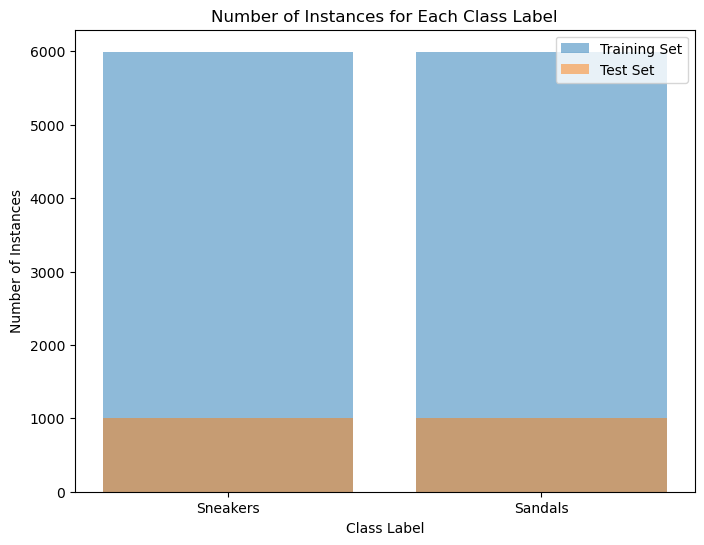

In [29]:
import matplotlib.pyplot as plt

# Get the counts of each class label in the training set and test set
training_label_counts = ss_training_label['label'].value_counts()
test_label_counts = ss_test_label['label'].value_counts()

# Check if the training set is imbalanced
if abs(training_label_counts[0] - training_label_counts[1]) > 0.5 * num_train_instances:
    print('The training set is imbalanced.')
else:
    print('The training set is balanced.')

# Plotting the bar plot
plt.figure(figsize=(8, 6))
plt.bar(training_label_counts.index, training_label_counts.values, alpha=0.5, label='Training Set')
plt.bar(test_label_counts.index, test_label_counts.values, alpha=0.5, label='Test Set')
plt.xticks([0, 1], ['Sneakers', 'Sandals'])
plt.xlabel('Class Label')
plt.ylabel('Number of Instances')
plt.title('Number of Instances for Each Class Label')
plt.legend()
plt.show()

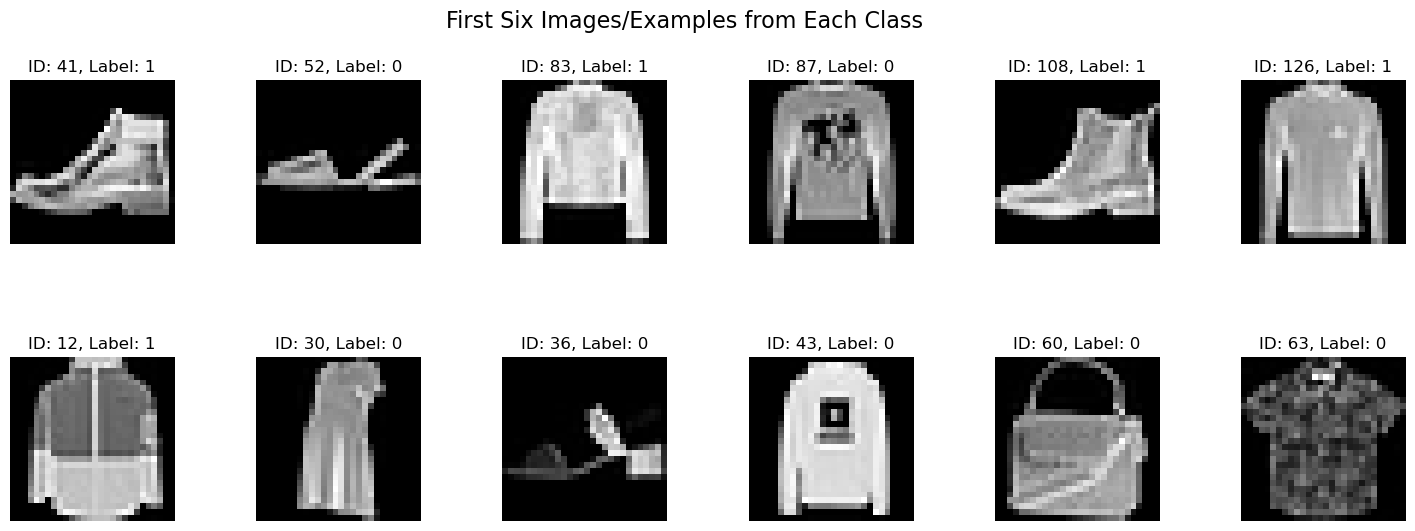

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# Define class names
class_names = ['Sneakers', 'Sandals']

# Create a 3x4 grid for plotting
fig, axs = plt.subplots(2, 6, figsize=(18, 6))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
axs = axs.ravel()

# Plot the first six images/examples from each class
for i in range(2):
    # Get the indices of the first six examples from each class
    indices = ss_training_label.index[ss_training_label['label'] == i][:6]
    
    for j, idx in enumerate(indices):
        # Get the image data and label
        image = np.array(ss_training_set.iloc[idx]).reshape(28, 28)
        label = ss_training_label.iloc[idx]['label']
        
        # Plot the image
        axs[i * 6 + j].imshow(image, cmap='gray')
        axs[i * 6 + j].set_title(f'ID: {idx}, Label: {label}')
        axs[i * 6 + j].axis('off')

plt.suptitle('First Six Images/Examples from Each Class', fontsize=16)
plt.show()
